In [2]:
import sys
sys.path.append('../../../lib')
from tqdm import tqdm
from scipy.signal import fftconvolve
import numpy as np
import os
import matplotlib.pyplot as plt
from fast_detection_methods import trajectory_gauss, trajectory_mean, trajectory_corr, fit_gaussian, find_ideal_R,most_common_value
from movie_processing import movie_to_array, clean_problem_pixels
#from pipython.datarectools import getservotime
import cv2
#core.set_exposure(0.5)##sets the cameras exposure time for snapshots to half a milisecond
from SpectralMechanicsAnalysis import mean_back_realxation, Data

In [3]:
"Z:\Julian\Hydrogel\measurement_2\25_khz\corr\y_trajecories.npy"

'Z:\\Julian\\Hydrogel\\measurement_2\x15_khz\\corr\\y_trajecories.npy'

In [4]:
data_path = r'\\134.76.13.158\betzlab\Julian\Hydrogel\measurement_2\25_khz'
#print all files at the path
#print(os.listdir(data_path+"/mean/x_trajecories.npy"))

tra_mean = np.load(data_path+"/mean/x_trajecories.npy")
tra_gauss = np.load(data_path+"/gauss_0/x_trajecories.npy")
tra_corr = np.load(data_path+"/corr/x_trajecories.npy")

tra_mean_y = np.load(data_path+"/mean/y_trajecories.npy")
tra_gauss_y = np.load(data_path+"/gauss_0/y_trajecories.npy")
tra_corr_y = np.load(data_path+"/corr/y_trajecories.npy")



In [5]:
def powerspectrum(trajectory, dt, k_max=None):
    # Compute the FFT of the trajectory
    trajectory_fft = np.fft.fft(trajectory)
    if k_max != None:
        k_max = min(k_max, len(trajectory) // 2)
    else:
        k_max = len(trajectory) // 2

    f_ks = np.arange(1, k_max+1) /(len(trajectory) * dt)

    frequncy_indeces = np.arange(1, k_max+1)
    
    # Only consider up to k_max frequencies
    truncated_fft = trajectory_fft[frequncy_indeces]
    
    # Compute the power spectrum
    power_spectrum = np.abs(truncated_fft)**2 /len(trajectory)

        
    return f_ks, power_spectrum

In [6]:
fk, ps_mean = powerspectrum(tra_mean, 1/2000)
fk, ps_gauss = powerspectrum(tra_gauss, 1/2000)
fk, ps_corr = powerspectrum(tra_corr, 1/2000)

In [7]:
sigma_sq_mean = np.mean(ps_mean[-100:])
sigma_sq_gauss = np.mean(ps_gauss[-100:])
sigma_sq_corr = np.mean(ps_corr[-100:])

def noise(sigma_sq,nm_pro_pixel):
    return np.sqrt(sigma_sq*nm_pro_pixel)

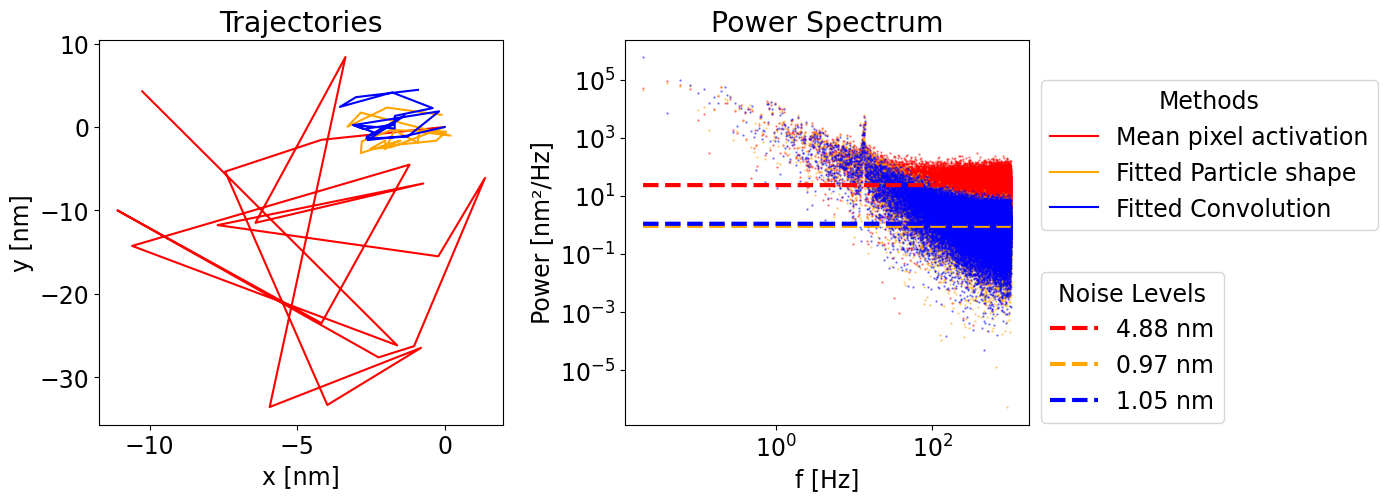

In [29]:
#plot the forst n_plot steps from each trajectory on the left and the powerspectrum on the right
nm_pro_pixel = (0.036768956332537246 * 1000)
n_plot = 20
colours = ["red", "orange", "blue"]
plt.rcParams.update({'font.size': 17})

line_thickness = 3

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3)  # Increase the horizontal spacing between subplots
#set the size of the first subplot
ax[0].plot(tra_mean[:n_plot]*nm_pro_pixel,tra_mean_y[:n_plot]*nm_pro_pixel, color=colours[0], label="Mean pixel activation")
ax[0].plot(tra_gauss[:n_plot]*nm_pro_pixel,tra_gauss_y[:n_plot]*nm_pro_pixel, color=colours[1], label="Fitted Particle shape")
ax[0].plot(tra_corr[:n_plot]*nm_pro_pixel,tra_corr_y[:n_plot]*nm_pro_pixel, color=colours[2], label="Fitted Convolution")

ax[0].set_xlabel("x [nm]")
ax[0].set_ylabel("y [nm]")
ax[0].title.set_text('Trajectories')

ax[1].scatter(fk, ps_mean*nm_pro_pixel**2, s=.4,c=colours[0], alpha=0.5)
ax[1].plot(fk, sigma_sq_mean*np.ones(len(fk))*nm_pro_pixel**2, c=colours[0], linestyle='--', label =f"{noise(sigma_sq_mean,nm_pro_pixel**2):.2f} nm", linewidth=line_thickness)
ax[1].scatter(fk, ps_gauss*nm_pro_pixel**2, s=.4,c=colours[1], alpha=0.5)
ax[1].plot(fk, sigma_sq_gauss*np.ones(len(fk))*nm_pro_pixel**2, c=colours[1], linestyle='--', label =f"{noise(sigma_sq_gauss,nm_pro_pixel**2):.2f} nm", linewidth=line_thickness)
ax[1].scatter(fk, ps_corr*nm_pro_pixel**2, s=.4,c=colours[2], alpha=0.5)
ax[1].plot(fk, sigma_sq_corr*np.ones(len(fk))*nm_pro_pixel**2, c=colours[2], linestyle='--', label =f"{noise(sigma_sq_corr,nm_pro_pixel**2):.2f} nm", linewidth=line_thickness)
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlabel("f [Hz]")
ax[1].set_ylabel("Power [nm²/Hz]")
ax[1].title.set_text('Power Spectrum')
# Create legends
legend1 = ax[0].legend(loc='center left', bbox_to_anchor=(2.3, 0.7), title="Methods")
legend2 = ax[1].legend(loc='center left', bbox_to_anchor=(1., 0.2), title="Noise Levels")

plt.show()


In [79]:
nm_pro_pixel = (0.036768956332537246 * 1000)**2
colours = ["red", "blue", "yellow"]
plt.rcParams.update({'font.size': 17})
plt.figure()
plt.scatter(fk, ps_mean*nm_pro_pixel, s=.4,c=colours[0], alpha=0.5)
plt.scatter(fk, ps_gauss*nm_pro_pixel, s=.4,c=colours[1], alpha=0.5)
plt.scatter(fk, ps_corr*nm_pro_pixel, s=.4,c=colours[2], alpha=0.5)
line_width = 3
plt.plot(fk, sigma_sq_mean*np.ones(len(fk))*nm_pro_pixel, c=colours[0], linewidth=line_width, linestyle='--', label =f"noise: {noise(sigma_sq_mean,nm_pro_pixel):.2f} nm")
plt.plot(fk, sigma_sq_gauss*np.ones(len(fk))*nm_pro_pixel, c=colours[1], linewidth=line_width, linestyle='--', label =f"noise: {noise(sigma_sq_gauss,nm_pro_pixel):.2f} nm")
plt.plot(fk, sigma_sq_corr*np.ones(len(fk))*nm_pro_pixel, c=colours[2], linewidth=line_width, linestyle='--', label =f"noise: {noise(sigma_sq_corr,nm_pro_pixel):.2f} nm")
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD [nm$^2$/Hz]")
plt.legend()

plt.savefig(r'C:\Users\jschulz\Desktop\resolution_plot.svg', format='svg')


In [ ]:
colours = ["00141E","00B3BC","#B6A700"]

In [123]:
from SpectralMechanicsAnalysis.data_handeling import load_data

In [131]:
path_active_data = r'\\134.76.13.158\\betzlab\\Julian\cell_beats\11_03_24\sample_2\2_khz_trajectories\datax.pkl'
path_passive_data = r'\\134.76.13.158\betzlab\Julian\Hydrogel\measurement_2\1_khz\gauss_0\x_trajecories.npy'

active_data = load_data(path_active_data).reconstructed_x
active_data = active_data[::2]
passive_data = np.load(path_passive_data)

t_active = np.arange(0, len(active_data)*1/1000, 1/1000)
t_passive = np.arange(0, len(passive_data)*1/1000, 1/1000)

In [128]:
data_passive = Data(t_passive, passive_data, typical_peak_number=1, max_peak_percentage=.9, log_weighted=True, unweighted_postfit = True)
data_passive.create_PSD()
data_passive.bayesian_update()
data_passive.peaks = []
data_passive.max_peak_percentage = 0.8
data_passive.find_peaks(max_iter=5)


In [152]:

data_passive.create_reconstructed_data()

dt = 1/1000
tau_list = np.array([1,2,10,20])*dt
T = .5

mbr_active = [mean_back_realxation(dt/2, active_data, tau, T) for tau in tau_list]
mbr_passive = [mean_back_realxation(dt, data_passive.reconstructed_x, tau, T) for tau in tau_list]
t_mbr_active = np.arange(0, len(mbr_active[0]))*dt/2
t_mbr_passive = np.arange(0, len(mbr_passive[0]))*dt

100%|██████████| 24079/24079 [00:00<00:00, 234215.47it/s]


In [151]:
plt.plot(t_mbr_passive, mbr_passive[0], label = f"Passive, $\\tau = {tau_list[0]}$")

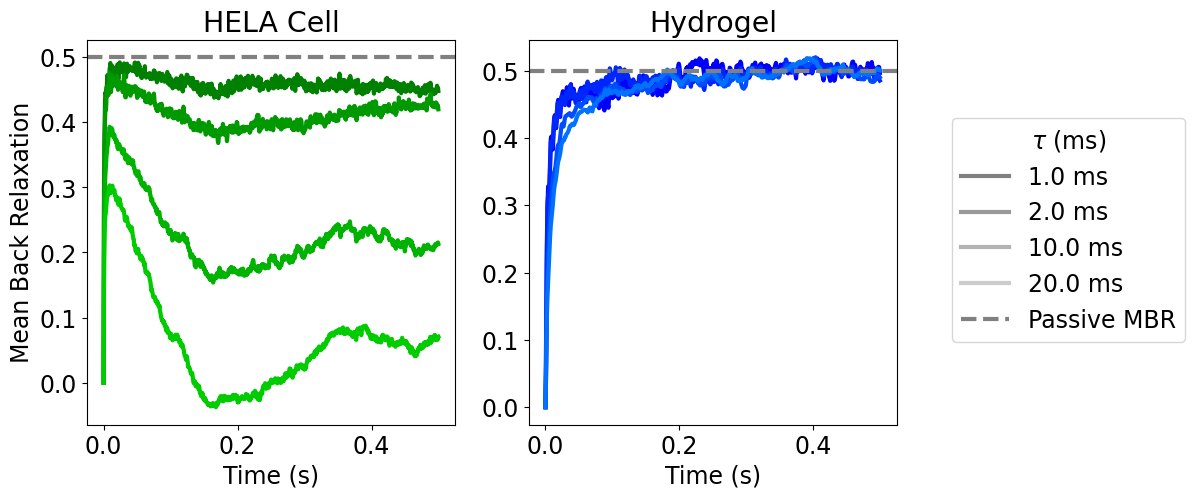

In [178]:
import matplotlib.pyplot as plt
import numpy as np

line_thickness = 3

# Define colors for active and passive plots
active_colors = ['#008000', '#009900', '#00b300', '#00cc00', '#00e600', '#00ff00']  # Dark to bright green
passive_colors = ['#0000ff', '#0026ff', '#004cff', '#0072ff', '#0099ff', '#00bfff']  # Dark to bright blue
#the same intensities in grey:
grey_colors = ['#808080', '#999999', '#b3b3b3', '#cccccc', '#e6e6e6', '#ffffff']  # Dark to bright green

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

# Plot active and passive data
for i, tau in enumerate(tau_list):
    ax1.plot(t_mbr_active, mbr_active[i], color=active_colors[i], linewidth  = line_thickness)
    ax2.plot(t_mbr_passive, mbr_passive[i], color=passive_colors[i], linewidth  = line_thickness)

# Mark the 0.5 line in both plots
ax1.axhline(y=0.5, color='gray', linestyle='--', lw = line_thickness)
ax2.axhline(y=0.5, color='gray', linestyle='--', label="Passive MBR", lw = line_thickness)

# Set titles
ax1.set_title("HELA Cell")
ax2.set_title("Hydrogel")

ax1.set_xlabel("Time (s)")
ax2.set_xlabel("Time (s)")

# Set y label
ax1.set_ylabel("Mean Back Relaxation")

# Move the legend outside the plot
plt.subplots_adjust(right=0.8)  # Adjust the right margin to make space for the legend

for i, tau in enumerate(tau_list):
    ax1.plot([], [], color=grey_colors[i], label=f"{tau * 1000 } ms", linewidth  = line_thickness)

# Add the shared legend
fig.legend(loc='center right', title=r"$\tau$ (ms)", bbox_to_anchor=(1.05, 0.5), ncol=1)

# Show the plot
plt.show()

In [169]:
?plt.axhline

Signature: plt.axhline(y=0, xmin=0, xmax=1, **kwargs)
Docstring:
Add a horizontal line across the Axes.

Parameters
----------
y : float, default: 0
    y position in data coordinates of the horizontal line.

xmin : float, default: 0
    Should be between 0 and 1, 0 being the far left of the plot, 1 the
    far right of the plot.

xmax : float, default: 1
    Should be between 0 and 1, 0 being the far left of the plot, 1 the
    far right of the plot.

Returns
-------
`~matplotlib.lines.Line2D`

Other Parameters
----------------
**kwargs
    Valid keyword arguments are `.Line2D` properties, except for
    'transform':

    Properties:
    agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
    alpha: scalar or None
    animated: bool
    antialiased or aa: bool
    clip_box: `.Bbox`
    clip_on: bool
    clip_path: Patch or (Path, Transform) or None
    color or c: col